# Running the Circuit Model with its Modulation

In [1]:
import matplotlib.pylab as plt
import numpy as np
import plot_tools as pt

## Fetching the Time-Varying Modulation

In [2]:
from src.Modulation import Events, build_arrays, EpisodeLength, Fraction, Smoothing
#plt.subplots_adjust(bottom=.4, top=.99, hspace=.8)
t, Neuromodulatory, Sensory = build_arrays(Events)

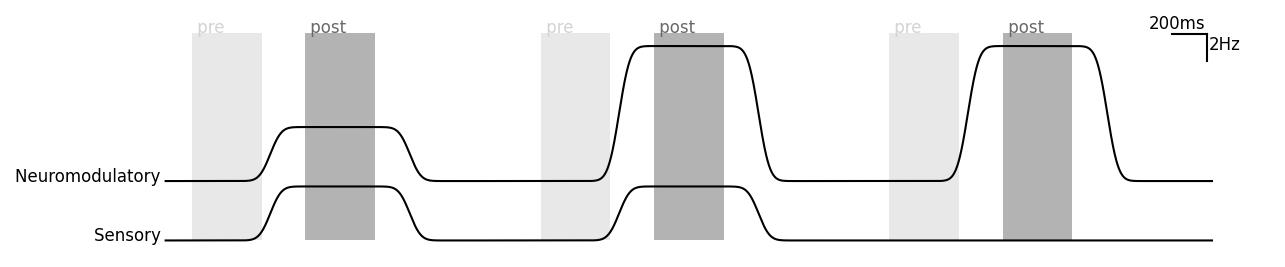

In [3]:
fig, ax = plt.subplots(1, figsize=(10,2))

ax.plot(t, Sensory, 'k-')
ax.annotate('Sensory ', (0,0), ha='right')
ax.plot(t, 1.1*Sensory.max()+Neuromodulatory, 'k-')
ax.annotate('Neuromodulatory ', (0,1.1*Sensory.max()), ha='right')

Width = EpisodeLength*Fraction-8*Smoothing
PREs, POSTs = [], []
Max = 1.1*(Sensory.max()+Neuromodulatory.max())
for e, Event in enumerate(Events):
    t0, tcenter = e*EpisodeLength, (e+.5)*EpisodeLength
    PREs.append([t0+3*Smoothing,t0+3*Smoothing+Width])
    ax.fill_between(PREs[e], [0,0], Max*np.ones(2), color='lightgray', alpha=.5, lw=0)
    ax.annotate(' pre', (PREs[e][0], Max), color='lightgray')
    POSTs.append([tcenter-Width/2.,tcenter+Width/2.])
    ax.fill_between(POSTs[e], [0,0], Max*np.ones(2), color='dimgray', alpha=.5, lw=0)
    ax.annotate(' post', (POSTs[e][0], Max), color='dimgray')
    
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=200, Xbar_label='200ms', Ybar=2, Ybar_label='2Hz')
pt.set_plot(ax, [], xticks=[])

In [4]:
from src.ntwk_sim import run_ntwk_sim
from src.CoupledCircuit import Model, REC_POPS, COLORS
from neural_network_dynamics import ntwk

AFF_POPS = ['BgExc', 'ExcToVip', 'ExcToThal']

Model['tstop'] = t[-1]+t[1]
NTWK = run_ntwk_sim(Model, REC_POPS,
                    AFF_POPS=AFF_POPS,
                    AFF_RATE_ARRAYS = [Model['F_BgExc']+0*t, 
                                       Neuromodulatory,
                                       Neuromodulatory+Sensory],
                   SEED=1, verbose=False)

ntwk.recording.write_as_hdf5(NTWK, filename='data/model-run.h5')

### Visualize the Circuit Dynamics

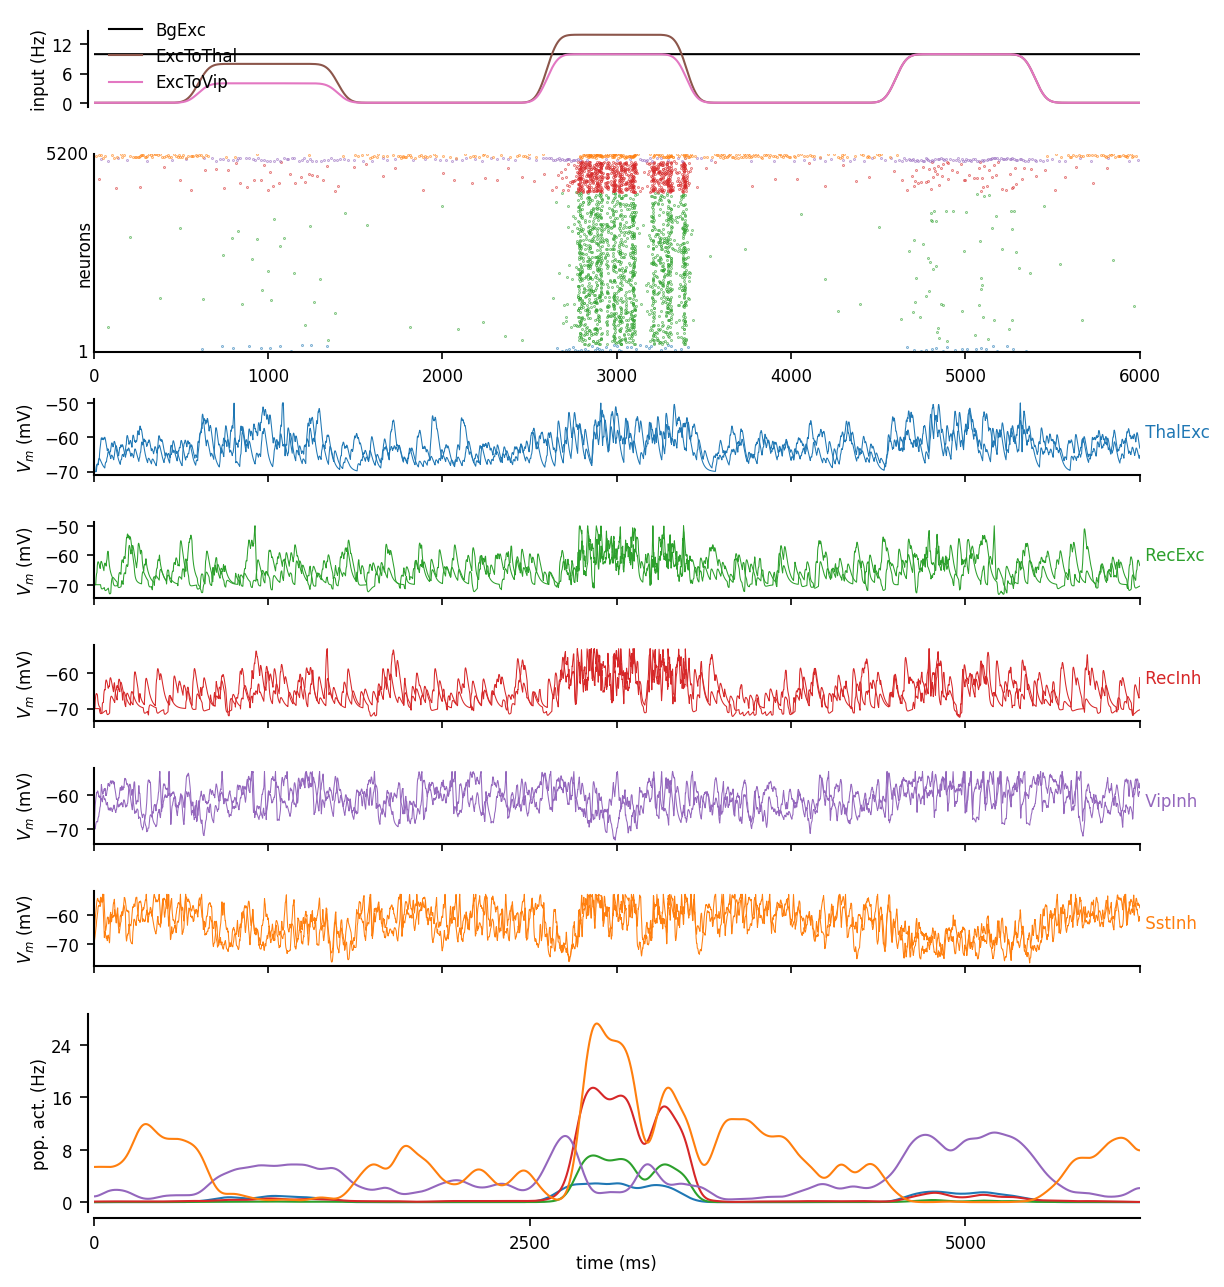

In [5]:
data = ntwk.recording.load_dict_from_hdf5('data/model-run.h5')
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

## Analyze

In [6]:
data = ntwk.recording.load_dict_from_hdf5('data/model-run.h5')
from src.CoupledCircuit import Model, REC_POPS, COLORS
RESP = []
for e, event in enumerate(Events):
    RESP.append({})
    for pop in ['RecExc', 'VipInh', 'SstInh']:
        RESP[e][pop] = {}
        for key, T in zip(['pre','post'], [PREs[e], POSTs[e]]):
            cond = (t>T[0]) & (t<T[1])
            RESP[e][pop][key] = np.mean(data['POP_ACT_%s'%pop][cond])

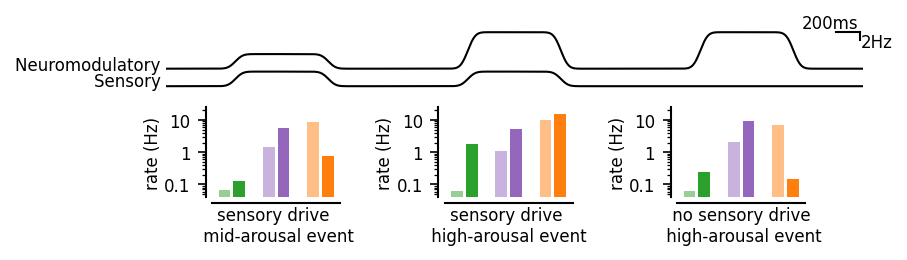

In [7]:
fig, ax = plt.subplots(1, figsize=(6,5))
plt.subplots_adjust(bottom=0.8)

ax.plot(t, Sensory, 'k-')
ax.annotate('Sensory ', (0,0), ha='right')
ax.plot(t, 1.2*Sensory.max()+Neuromodulatory, 'k-')
ax.annotate('Neuromodulatory ', (0,1.1*Sensory.max()), ha='right')
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=200, Xbar_label='200ms', Ybar=2, Ybar_label='2Hz')
pt.set_plot(ax, [], xticks=[], xlim=[t[0], t[-1]])

INSETS = []
colors =  ['tab:green', 'tab:purple', 'tab:orange']

for e, event in enumerate(Events):
    X0, W0 = (e+.2)/len(Events), .55/len(Events)
    INSETS.append(pt.inset(ax, [X0, -1.8, W0, 1.5,]))
    for p, pop in enumerate(['RecExc', 'VipInh', 'SstInh']):
        for k, key in enumerate(['pre','post']):
            INSETS[e].bar([3*p+k], [RESP[e][pop][key]+5e-2],
                          alpha=0.5*(1+k), color=colors[p])    
    pt.annotate(INSETS[e], event['name'], (0.5, -.1),
                ha='center', va='top')
for i, inset in enumerate(INSETS):
    pt.set_plot(inset, xticks=[], yticks=[0.1,1.,10], yticks_labels=['0.1','1','10'],
                ylim=[4e-2, 25], yscale='log', ylabel='rate (Hz)')    

## Seed Variations

In [4]:
SEEDS = range(20)

In [53]:
from src.ntwk_sim import run_ntwk_sim
from src.CoupledCircuit import Model, REC_POPS, COLORS
from neural_network_dynamics import ntwk

AFF_POPS = ['BgExc', 'ExcToVip', 'ExcToThal']

Model['tstop'] = t[-1]+t[1]

for seed in SEEDS:
    NTWK = run_ntwk_sim(Model, REC_POPS,
                        AFF_POPS=AFF_POPS,
                        AFF_RATE_ARRAYS = [Model['F_BgExc']+0*t, 
                                           Neuromodulatory,
                                           Neuromodulatory+Sensory],
                        recording_settings = dict(with_Vm=10),
                        SEED=seed, verbose=False)

    ntwk.recording.write_as_hdf5(NTWK, filename='data/model-run-%i.h5' % seed)

In [5]:
from src.CoupledCircuit import Model, REC_POPS, COLORS
from scipy.ndimage import gaussian_filter1d
from neural_network_dynamics import ntwk
from src.Modulation import Events, build_arrays, EpisodeLength, Fraction, Smoothing
import numpy as np
#plt.subplots_adjust(bottom=.4, top=.99, hspace=.8)
t, Neuromodulatory, Sensory = build_arrays(Events)


RESP = {}
for pop in REC_POPS:
    RESP[pop] = []
    
for seed in SEEDS:
    data = ntwk.recording.load_dict_from_hdf5('data/model-run-%i.h5' % seed)
    for pop in REC_POPS:
        RESP[pop].append(gaussian_filter1d(data['POP_ACT_%s'%pop], int(Smoothing/t[1])))

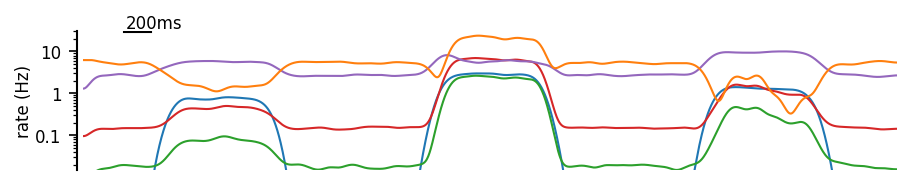

In [6]:
import matplotlib.pylab as plt
import plot_tools as pt
from scipy import stats
fig, ax = plt.subplots(1, 1, figsize=(7,1.2))

min_rate = 1e-2
#pt.set_plot(ax, ['left'], ylabel='rate (Hz)',
            #yscale='log', ylim=[1.5*min_rate,30], yticks=[0.1,1,10], yticks_labels=['0.1','1','10'], 
#            xlim=[t[0], t[-1]])

for k, key in enumerate(REC_POPS):
    y = np.mean(RESP[key], axis=0)[::30]
    sy = np.std(RESP[key], axis=0)[::30]
    ax.plot(t[::30], y, color=COLORS[k])
    #ax.fill_between(t[::30], y, y+sy, color=COLORS[k], lw=0, alpha=.1)
    #ax.fill_between(t[::30], y, y-sy, color=COLORS[k], lw=0, alpha=.1)
    
    #pt.plot(t[::30], y, sy = sy, color=COLORS[k], ax=ax)
    
pt.set_plot(ax, ['left'], ylabel='rate (Hz)',
            yscale='log', ylim=[1.5*min_rate,30], yticks=[0.1,1,10], yticks_labels=['0.1','1','10'], 
            xlim=[t[0], t[-1]])

pt.draw_bar_scales(ax, Xbar=200, Xbar_label='200ms', Ybar=1e-12)
fig.savefig('/Users/yann/Desktop/temp.svg')

RecExc pre : 0.02 +/- 0.00 
RecExc post : 0.08 +/- 0.02 
VipInh pre : 2.77 +/- 0.35 
VipInh post : 5.76 +/- 0.47 
SstInh pre : 5.17 +/- 0.73 
SstInh post : 1.38 +/- 0.36 
RecExc pre : 0.02 +/- 0.00 
RecExc post : 2.43 +/- 0.35 
VipInh pre : 2.77 +/- 0.26 
VipInh post : 5.81 +/- 0.65 
SstInh pre : 5.24 +/- 0.64 
SstInh post : 21.47 +/- 3.99 
RecExc pre : 0.02 +/- 0.00 
RecExc post : 0.36 +/- 0.28 
VipInh pre : 2.85 +/- 0.36 
VipInh post : 9.61 +/- 0.64 
SstInh pre : 5.15 +/- 0.82 
SstInh post : 1.72 +/- 2.40 


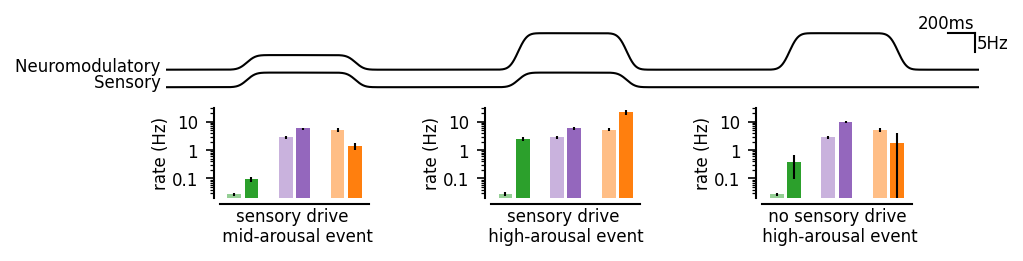

In [10]:
from src.CoupledCircuit import Model, REC_POPS, COLORS
RESP = []
for e, event in enumerate(Events):
    RESP.append({})
    for pop in ['RecExc', 'VipInh', 'SstInh']:
        RESP[e][pop] = {'pre':[], 'post':[]}
        for seed in SEEDS:
            data = ntwk.recording.load_dict_from_hdf5('data/model-run-%i.h5' % seed)
            for key, T in zip(['pre','post'], [PREs[e], POSTs[e]]):
                cond = (t>T[0]) & (t<T[1])
                RESP[e][pop][key].append(np.mean(data['POP_ACT_%s'%pop][cond]))

fig, ax = plt.subplots(1, figsize=(7,5))
plt.subplots_adjust(bottom=0.8)

ax.plot(t, Sensory, 'k-')
ax.annotate('Sensory ', (0,0), ha='right')
ax.plot(t, 1.2*Sensory.max()+Neuromodulatory, 'k-')
ax.annotate('Neuromodulatory ', (0,1.1*Sensory.max()), ha='right')
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=200, Xbar_label='200ms', Ybar=5, Ybar_label='5Hz')
pt.set_plot(ax, [], xticks=[], xlim=[t[0], t[-1]])

INSETS = []
colors =  ['tab:green', 'tab:purple', 'tab:orange']

def lmi(pre, post):
    return np.clip((post-pre)/(pre+post), -1, 1)
    
for e, event in enumerate(Events):
    X0, W0 = (e+.2)/len(Events), .55/len(Events)
    INSETS.append(pt.inset(ax, [X0, -1.8, W0, 1.5,]))
    for p, pop in enumerate(['RecExc', 'VipInh', 'SstInh']):
        for k, key in enumerate(['pre','post']):
            INSETS[e].bar([3*p+k], 
                          [np.mean(RESP[e][pop][key])+1e-2],
                          yerr=[np.std(RESP[e][pop][key])],
                          alpha=0.5*(1+k), color=colors[p])
        #pt.annotate(INSETS[e], 'lmi=%.2f' % lmi(np.mean(RESP[e][pop]['pre']), np.mean(RESP[e][pop]['post'])),
        #            (3*p, 30), xycoords='data', rotation=90)
            print(pop, key, ': %.2f +/- %.2f ' % (np.mean(RESP[e][pop][key]), np.std(RESP[e][pop][key])))
    pt.annotate(INSETS[e], event['name'], (0.5, -.1),
                ha='center', va='top')
for i, inset in enumerate(INSETS):
    pt.set_plot(inset, xticks=[], 
                yscale='log', yticks=[0.1,1.,10], yticks_labels=['0.1','1','10'],
                ylim=[2e-2, 30], 
                ylabel='rate (Hz)') 

#fig.savefig('/Users/yann/Desktop/temp.svg')

-- event 3
RecExc delta rate : 0.06 +/- 0.02 
RecExc delta rate : 2.41 +/- 0.35 
RecExc delta rate : 0.35 +/- 0.28 
-- event 3
VipInh delta rate : 3.00 +/- 0.63 
VipInh delta rate : 3.04 +/- 0.69 
VipInh delta rate : 6.75 +/- 0.85 
-- event 3
SstInh delta rate : -3.78 +/- 0.88 
SstInh delta rate : 16.23 +/- 4.05 
SstInh delta rate : -3.43 +/- 2.50 


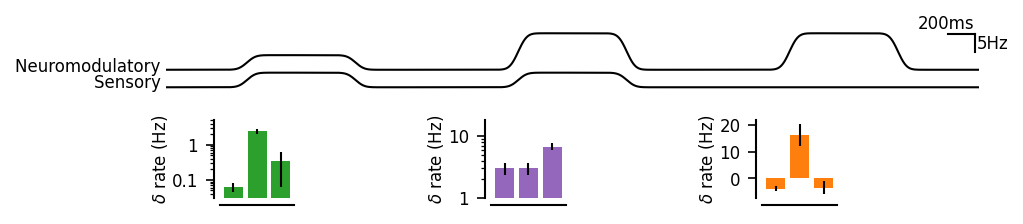

In [27]:
from src.CoupledCircuit import Model, REC_POPS, COLORS
RESP = []
for e, event in enumerate(Events):
    RESP.append({})
    for pop in ['RecExc', 'VipInh', 'SstInh']:
        RESP[e][pop] = {'pre':[], 'post':[]}
        for seed in SEEDS:
            data = ntwk.recording.load_dict_from_hdf5('data/model-run-%i.h5' % seed)
            for key, T in zip(['pre','post'], [PREs[e], POSTs[e]]):
                cond = (t>T[0]) & (t<T[1])
                RESP[e][pop][key].append(np.mean(data['POP_ACT_%s'%pop][cond]))

fig, ax = plt.subplots(1, figsize=(7,5))
plt.subplots_adjust(bottom=0.8)

ax.plot(t, Sensory, 'k-')
ax.annotate('Sensory ', (0,0), ha='right')
ax.plot(t, 1.2*Sensory.max()+Neuromodulatory, 'k-')
ax.annotate('Neuromodulatory ', (0,1.1*Sensory.max()), ha='right')
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=200, Xbar_label='200ms', Ybar=5, Ybar_label='5Hz')
pt.set_plot(ax, [], xticks=[], xlim=[t[0], t[-1]])

INSETS = []
colors =  ['tab:green', 'tab:purple', 'tab:orange']

def var(pre, post):
    return (post-pre)

POPS = ['RecExc', 'VipInh', 'SstInh']
for p, pop in enumerate(POPS):
    X0, W0 = (p+.2)/len(POPS), .55/len(POPS)
    INSETS.append(pt.inset(ax, [X0, -1.8, .5*W0, 1.3,]))
    print('-- event', e+1)
    for e, event in enumerate(Events):
        vars = [var(pre, post) for pre, post in zip(RESP[e][pop]['pre'], RESP[e][pop]['post'])]
        INSETS[p].bar([e], [np.mean(vars)],
                      yerr=[np.std(vars)],
                      color=colors[p])
        print(pop, 'delta rate', ': %.2f +/- %.2f ' % (np.mean(vars), np.std(vars)))

#pt.set_common_ylims(INSETS)
for i, inset in enumerate(INSETS):
    pt.set_plot(inset, xticks=[],
                #yscale='log', yticks=[0.1,1.,10], yticks_labels=['0.1','1','10'],
                #ylim=[2e-2, 30], 
                ylabel='$\delta$ rate (Hz)')    

pt.set_plot(INSETS[0], xticks=[], yscale='log', yticks=[.1,1], yticks_labels=['0.1', '1'],
            ylim=[3e-2, 5], ylabel='$\delta$ rate (Hz)')    
pt.set_plot(INSETS[1], xticks=[], yscale='log', yticks=[1,10], yticks_labels=['1', '10'],
            ylim=[.99, 18], ylabel='$\delta$ rate (Hz)')   

fig.savefig('/Users/yann/Desktop/temp.svg')

### Show a single trial

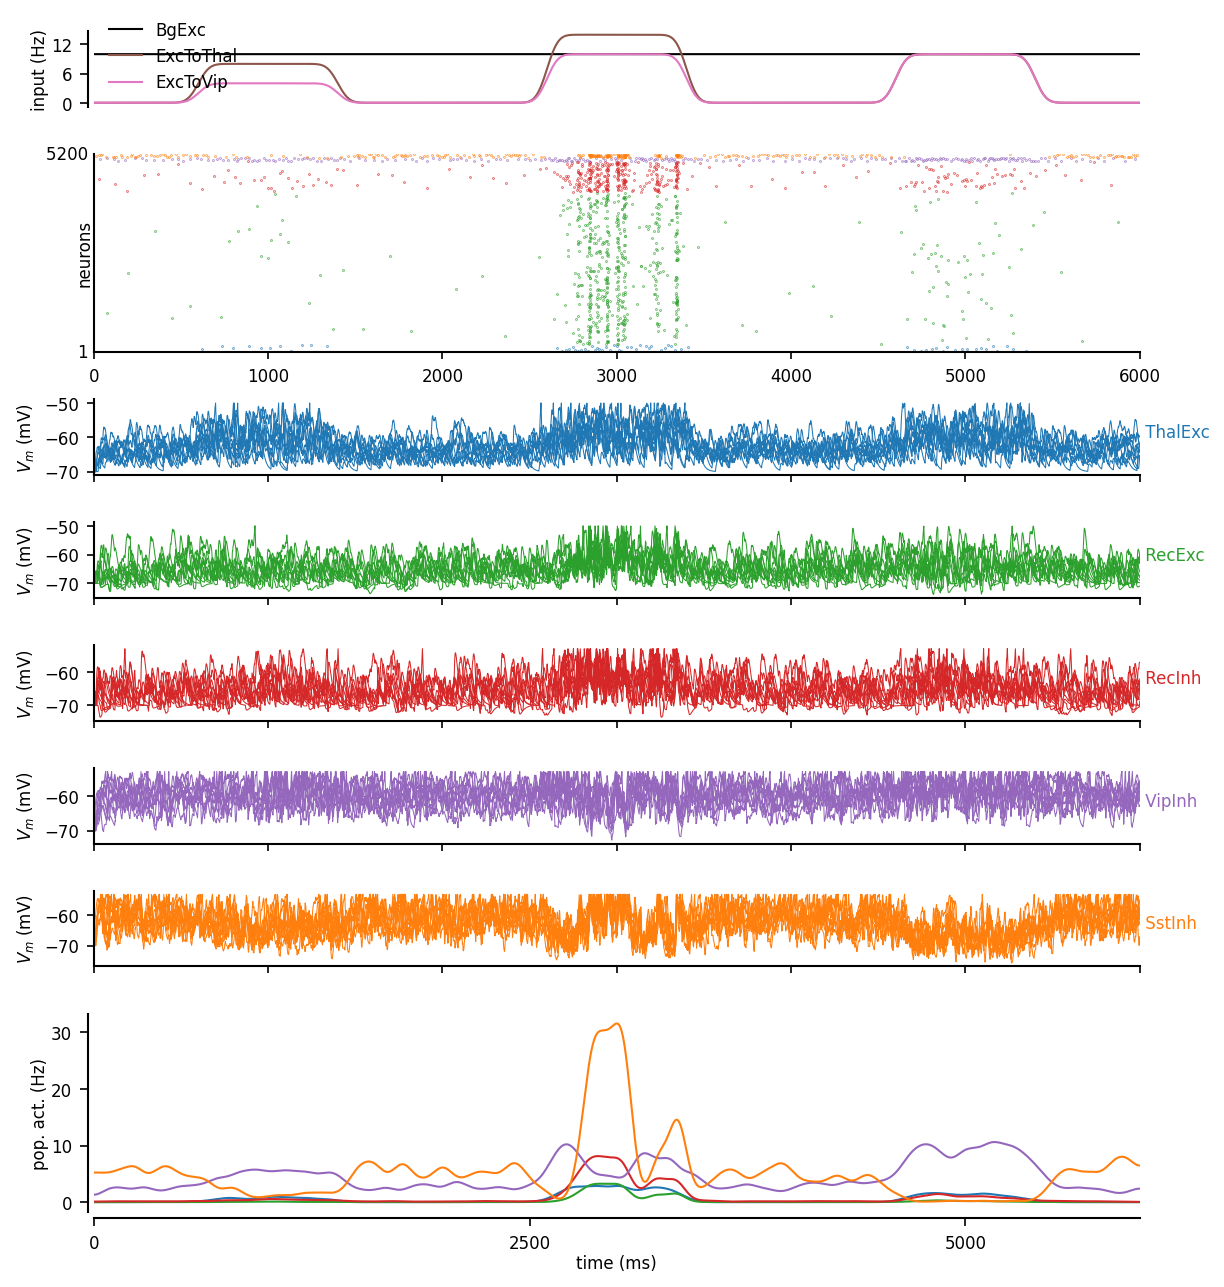

In [28]:
data = ntwk.recording.load_dict_from_hdf5('data/model-run-1.h5')

fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

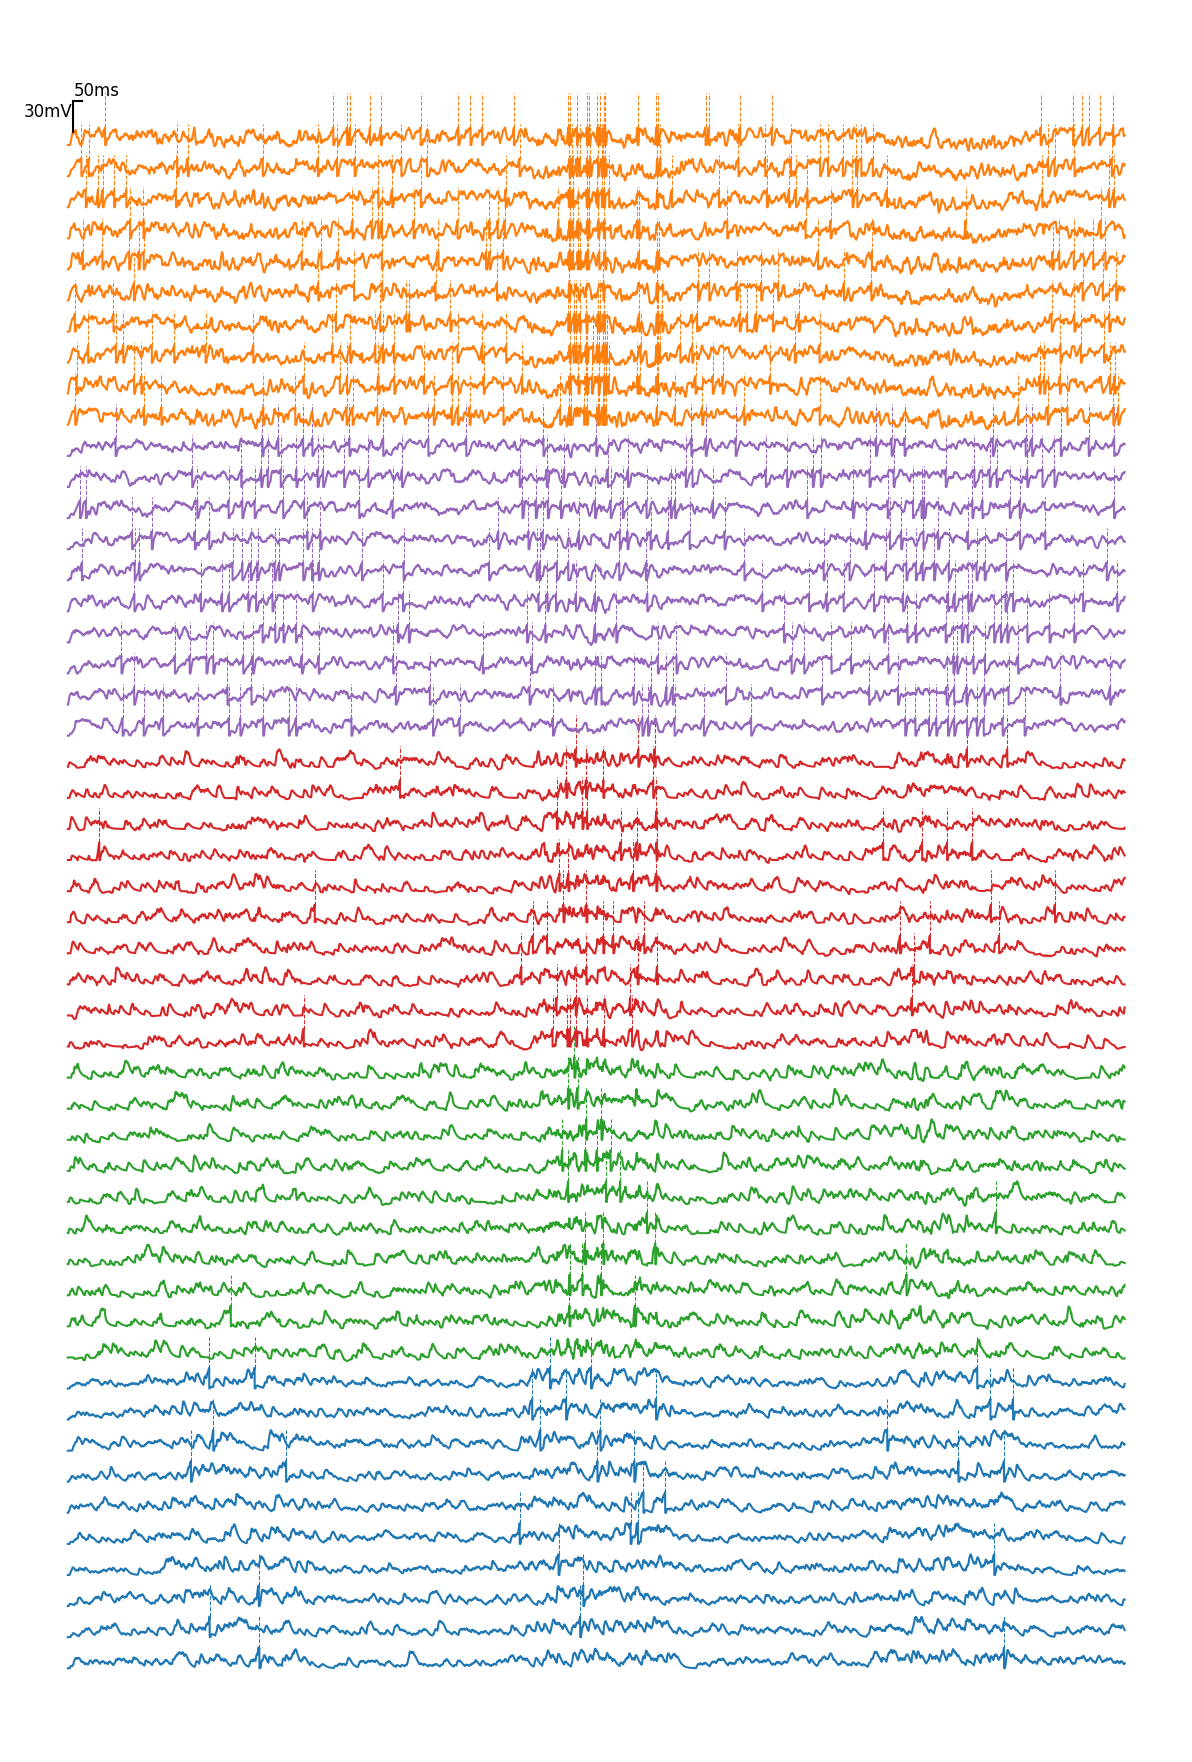

In [63]:
fig, ax = plt.subplots(1, figsize=(10,15))
ntwk.plots.shifted_Vms_subplot(data, ax, REC_POPS, COLORS,
                               [t[0], t[-1]],
                               v_shift=30,
                              spike_peak=-20)

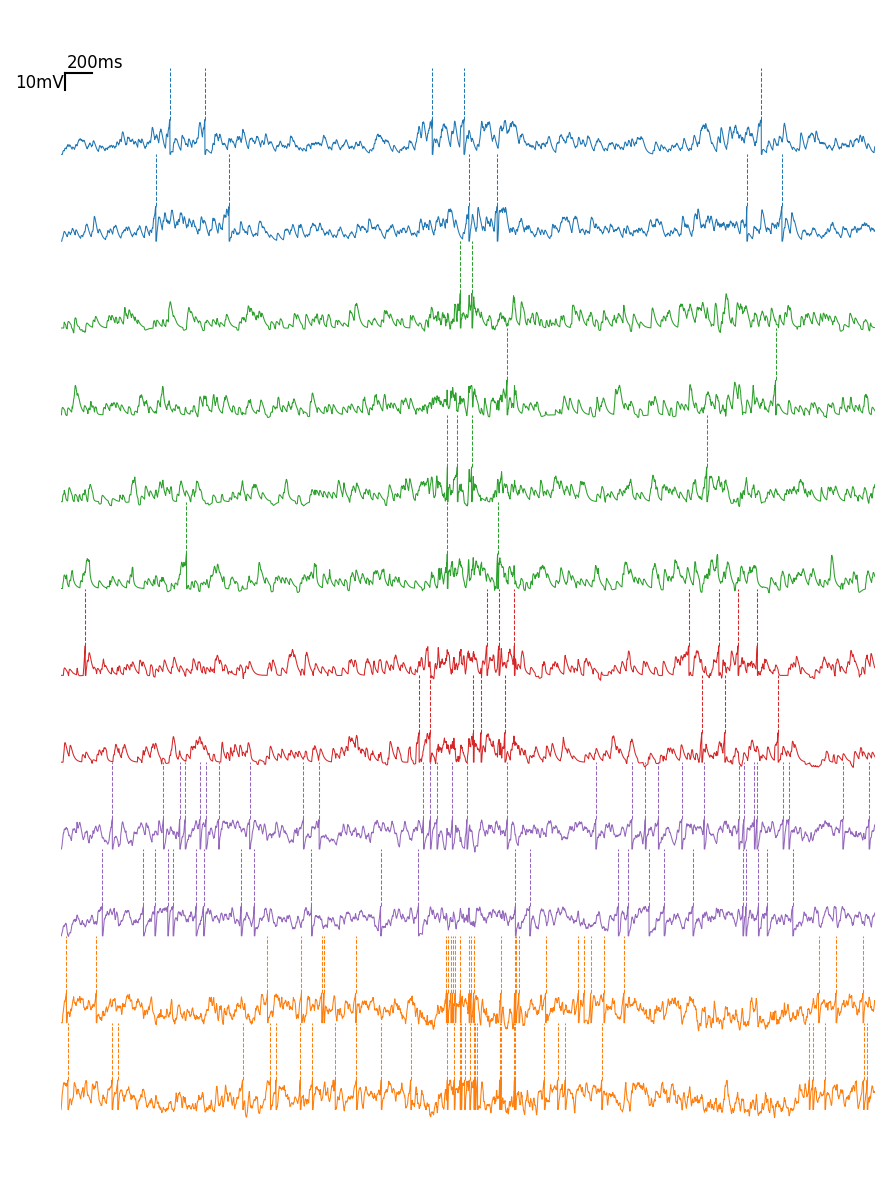

In [29]:
def example_Vms_subplot(data, ax,
                        POP_KEYS, PICKS, COLORS, 
                        v_shift=50, Tbar=50,
                        spike_peak = -20):

    shift = 0

    for i, tpop in zip(range(len(POP_KEYS)), POP_KEYS):

        if ('VMS_%s' % tpop) in data:

            t = np.arange(len(data['VMS_%s' % tpop][0]))*data['dt']

            for v in data['VMS_%s' % tpop][PICKS[i]]:

                ax.plot(t, v+shift, '-', lw=0.5, c=COLORS[i])

                if spike_peak is not None:
                    tspikes, threshold = ntwk.plots.find_spikes_from_Vm(t, v, data, tpop)
                    for ts in tspikes:
                        ax.plot([ts,ts],[threshold+shift,spike_peak+shift],
                                '--', c=COLORS[i], lw=0.5)
                shift += v_shift

    pt.draw_bar_scales(ax,
                       Xbar=200, Xbar_label='200ms', Ybar=10, Ybar_label='10mV')

    ax.set_xlim([t[0], t[-1]])
    ax.axis('off')

fig, ax = plt.subplots(figsize=(7,10))

PICKS = [range(2) for r in REC_POPS]

PICKS = [[6,9],
         [1,2,4,7],
         [3,6],
         [2,4],
         [1,3]]
example_Vms_subplot(data, ax, REC_POPS[::-1], PICKS[::-1], COLORS[::-1])
fig.savefig('/Users/yann/Desktop/temp.svg')